#Bounding Box Prediction from Scratch using PyTorch

Object detection is a very popular task in Computer Vision, where, given an image, you predict (usually rectangular) boxes around objects present in the image and also recognize the types of objects. There could be multiple objects in your image and there are various state-of-the-art techniques and architectures to tackle this problem like [Faster-RCNN](https://arxiv.org/pdf/1506.01497.pdf) and [YOLO v3](https://pjreddie.com/media/files/papers/YOLOv3.pdf).
This article talks about the case when there is only one object of interest present in an image. The focus here is more on how to read an image and its bounding box, resize and perform augmentations correctly, rather than on the model itself. The goal is to have a good grasp of the fundamental ideas behind object detection, which you can extend to get a better understanding of the more complex techniques.

# Road Signs Bounding Box Prediction using PyTorch

<b>Problem Statement:</b> Predict bounding box around a Road sign in a given image and also predict the type of road sign.

Problem Statement
Given an image consisting of a road sign, predict a bounding box around the road sign and identify the type of road sign.
There are four distinct classes these signs could belong to:

1) Traffic Light

2) Stop

3) Speed Limit

4) Crosswalk

This is called a multi-task learning problem as it involves performing two tasks — 

1) regression to find the bounding box coordinates, 

2) classification to identify the type of road sign

<b>Dataset:</b> https://www.kaggle.com/andrewmvd/road-sign-detection 

(title= Road Signs Dataset ,<br>
url= https://makeml.app/datasets/road-signs,<br>
journal= Make ML)<br>


In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#!unzip road_signs.zip
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/andrewmvd/road-sign-detection'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: x3smileyxd
Your Kaggle Key: ··········


  2%|▏         | 5.00M/218M [00:00<00:06, 32.6MB/s]

100%|██████████| 218M/218M [00:02<00:00, 85.0MB/s]


## Loading the data

In [5]:
images_path = Path('./road-sign-detection/images')
anno_path = Path('./road-sign-detection/annotations')

In [6]:
filelist = []
for directory_path, directory_name, files in os.walk(anno_path):
  for f in files:
    if f.endswith('.xml'):
      filelist.append(os.path.join(directory_path, f))

In [7]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [8]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,road-sign-detection/images/road186.png,300,400,crosswalk,192,168,220,197
1,road-sign-detection/images/road514.png,300,400,speedlimit,176,148,206,177
2,road-sign-detection/images/road660.png,300,400,speedlimit,132,189,193,250
3,road-sign-detection/images/road405.png,300,400,speedlimit,150,262,174,286
4,road-sign-detection/images/road222.png,300,400,speedlimit,154,188,168,201
...,...,...,...,...,...,...,...,...
872,road-sign-detection/images/road785.png,300,400,speedlimit,74,65,168,160
873,road-sign-detection/images/road620.png,300,400,speedlimit,123,222,150,250
874,road-sign-detection/images/road171.png,300,400,crosswalk,138,209,165,245
875,road-sign-detection/images/road226.png,300,400,speedlimit,134,175,156,197


In [9]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [10]:
print(df_train.shape)
df_train.sample(5)

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
702,road-sign-detection/images/road550.png,300,400,0,124,169,181,226
103,road-sign-detection/images/road91.png,400,400,1,155,243,247,358
820,road-sign-detection/images/road407.png,300,400,0,167,219,179,230
71,road-sign-detection/images/road855.png,300,400,0,94,86,134,125
426,road-sign-detection/images/road113.png,400,274,0,171,38,307,186


## Resizing images and bounding boxes

In [11]:
# Reading an image
def read_image(path):
    # print(cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB))
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [12]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int) # cast a pandas object to a specified dtype
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y) # returns a tuple of arrays, one for each dimension of arr, containing the indices of the non-zero elements in that dimension
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [13]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [14]:
# Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road-sign-detection/images_resized')
if not os.path.isdir( train_path_resized ) :
    os.mkdir( train_path_resized )  # make sure the directory exists
for index, row in df_train.iterrows():
    new_path, new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

### Sample Image

In [15]:
im = cv2.imread(str(df_train.values[0][0]))
bb = create_bb_array(df_train.values[0])
print(im.shape)

(400, 300, 3)


In [16]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([168., 192., 196., 219.], dtype=float32)

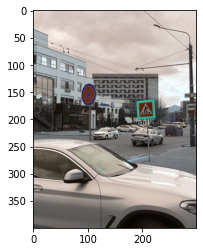

In [17]:
plt.imshow(im)

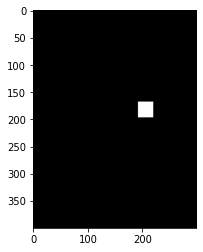

In [18]:
plt.imshow(Y, cmap='gray')

In [19]:
df_train.loc[0]

filename            road-sign-detection/images/road186.png
width                                                  300
height                                                 400
class                                                    2
xmin                                                   192
ymin                                                   168
xmax                                                   220
ymax                                                   197
new_path    road-sign-detection/images_resized/road186.png
new_bb                        [126.0, 285.0, 147.0, 328.0]
Name: 0, dtype: object

## Data augmentation

Functions in this section borrowed and modified from https://www.usfca.edu/data-institute/certificates/fundamentals-deep-learning 

In [20]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [21]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [22]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [23]:
df_train.loc[68]

filename            road-sign-detection/images/road452.png
width                                                  300
height                                                 400
class                                                    0
xmin                                                    94
ymin                                                   164
xmax                                                   167
ymax                                                   238
new_path    road-sign-detection/images_resized/road452.png
new_bb                        [123.0, 139.0, 178.0, 249.0]
Name: 68, dtype: object

In [24]:
df_train.values[68][9]

array([123., 139., 178., 249.], dtype=float32)

### Sample Image

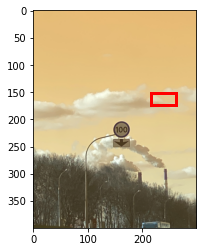

In [25]:
# original
im = read_image(str(df_train.values[101][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[101][-1])

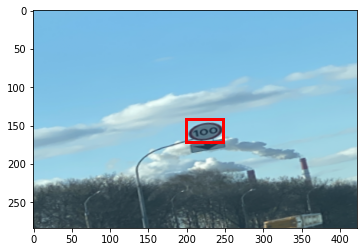

In [26]:
# after transformation
im, bb = transformsXY(str(df_train.values[101][-2]),df_train.values[101][-1],True)
show_corner_bb(im, bb)

In [27]:
df_train = df_train.reset_index()

In [28]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## Dataset

In [30]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [31]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [32]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [33]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [34]:
resnet = models.resnet34(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
layers = list(resnet.children())[:8]
layers

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

## Model

In [36]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

## Training

In [37]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [38]:
def train_epochs(model, optimizer, train_dl, val_dl, epochs=10, C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [39]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

What are [filters](https://www.geeksforgeeks.org/filter-in-python/)? 

Filters is normally used with Lambda functions to separate list, tuple, or sets.

In [40]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [41]:
train_epochs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.407 val_loss 647037.398 val_acc 0.085
train_loss 1.679 val_loss 320.093 val_acc 0.341
train_loss 1.619 val_loss 7.485 val_acc 0.659
train_loss 1.292 val_loss 3.851 val_acc 0.739
train_loss 1.138 val_loss 1.193 val_acc 0.750
train_loss 0.962 val_loss 1.036 val_acc 0.727
train_loss 0.940 val_loss 0.890 val_acc 0.773
train_loss 0.886 val_loss 0.988 val_acc 0.761
train_loss 0.861 val_loss 0.913 val_acc 0.739
train_loss 0.850 val_loss 1.000 val_acc 0.733
train_loss 0.834 val_loss 0.924 val_acc 0.750
train_loss 0.860 val_loss 2.132 val_acc 0.682
train_loss 0.929 val_loss 1.046 val_acc 0.739
train_loss 0.888 val_loss 1.702 val_acc 0.648
train_loss 1.033 val_loss 18.009 val_acc 0.267


1.033183899143453

In [42]:
update_optimizer(optimizer, 0.001)
train_epochs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.907 val_loss 1.059 val_acc 0.710
train_loss 0.851 val_loss 0.978 val_acc 0.739
train_loss 0.859 val_loss 1.053 val_acc 0.744
train_loss 0.826 val_loss 0.866 val_acc 0.767
train_loss 0.807 val_loss 0.877 val_acc 0.756
train_loss 0.795 val_loss 0.887 val_acc 0.756
train_loss 0.808 val_loss 0.879 val_acc 0.750
train_loss 0.793 val_loss 1.026 val_acc 0.750
train_loss 0.778 val_loss 0.844 val_acc 0.744
train_loss 0.776 val_loss 0.861 val_acc 0.756


0.7759152519889974

### Making predictions

In [43]:
# choose random image from validation set
X_val

,new_path,new_bb
710,road-sign-detection/images_resized/road62.png,"[84.0, 210.0, 150.0, 360.0]"
734,road-sign-detection/images_resized/road551.png,"[157.0, 165.0, 203.0, 255.0]"
244,road-sign-detection/images_resized/road369.png,"[105.0, 157.0, 145.0, 238.0]"
231,road-sign-detection/images_resized/road308.png,"[99.0, 144.0, 128.0, 204.0]"
291,road-sign-detection/images_resized/road726.png,"[117.0, 203.0, 178.0, 326.0]"
...,...,...
500,road-sign-detection/images_resized/road137.png,"[42.0, 231.0, 184.0, 373.0]"
215,road-sign-detection/images_resized/road814.png,"[119.0, 178.0, 144.0, 228.0]"
350,road-sign-detection/images_resized/road180.png,"[57.0, 117.0, 147.0, 246.0]"
81,road-sign-detection/images_resized/road696.png,"[161.0, 206.0, 181.0, 246.0]"


In [44]:
# resizing test image
im = read_image('./road-sign-detection/images_resized/road789.png')
im = cv2.resize(im, (int(1.49*300), 300))
if not os.path.isdir( './road-sign-detection/road_signs_test' ) :
    os.mkdir( './road-sign-detection/road_signs_test' )  # make sure the directory exists
cv2.imwrite('./road-sign-detection/road_signs_test/road789.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [45]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road-sign-detection/road_signs_test/road789.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [46]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [47]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 1.7325, -1.3075, -1.2458, -1.7411]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[104.5591, 166.3988, 154.1984, 249.0568]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [48]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(values=tensor([1.7325], device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([0], device='cuda:0'))

 Class predicted = speedlimit

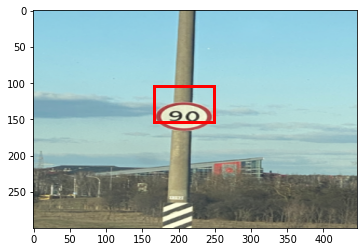

In [49]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])